In [34]:
import numpy as np
import pandas as pd
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import psycopg2
from sqlalchemy import create_engine
import os
import plotly.figure_factory as ff
POSTGRES_PASSWORD = os.getenv('POSTGRES_PASSWORD')

In [35]:
engine = create_engine('postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}'.format(
    user = 'postgres',
    password = POSTGRES_PASSWORD,
    host = 'postgres',
    port = 5432,
    db = 'congress'
))

In [36]:
myquery = '''
SELECT directordername, bioguideid
FROM members
ORDER BY lastname
'''

members = pd.read_sql_query(myquery, engine)
memberlist = [{'label': x, 'value': y} for x, y in zip(members['directordername'], members['bioguideid'])]

In [37]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

In [38]:
mymarkdown = '''

Congressional elections are usually all about the big national issues, but these Representatives and Senators work for local districts and states. Not all issues are the same everywhere. The purpose of this dashboard is to collect public data from these sources:

* [Official API for the U.S. Congress](https://api.congress.gov/)
* [Voteview](https://voteview.com/)
* [Open Secrets](https://opensecrets.org/open-data/api)
* [ProPublica's Data on Bills](https://www.propublica.org/)

'''

In [59]:
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div(
    [
        ### Stuff on top
        html.H1("Know Your Representatives in Congress"),
        html.H2("Data collected from APIs from Congress.gov, Open Secrets, Voteview.com, and ProPublica"),
        html.H3("DS 6600: Data Engineering 1, UVA Data Science"),

        #### Side Bar
        html.Div([
            dcc.Markdown("Please select a Representative or Senator"),
            dcc.Dropdown(id = 'member', options = memberlist, value = 'A000370'),
            dcc.Markdown(mymarkdown),
            
        ], style = {'width': '24%', 'float':'left'}),
        
        ### main bar
        html.Div([
            dcc.Tabs([
                dcc.Tab(label = 'Biographical Info', children = [
                    dcc.Graph(id='biotable')
                ]),
                dcc.Tab(label = 'Bill Sponsorship', children = [
                    ## pass
                ]),
                dcc.Tab(label = 'Voting and Ideology', children = [
                    ## pass
                ]),
                dcc.Tab(label = 'Donors and Financial Info', children = [
                    ## pass
                ]),
            ])
        ], style = {'width':'74%', 'float':'right'})
    ]
)

### operate on the next that appears
@app.callback([Output(component_id = 'biotable', component_property = 'figure')], 
             [Input(component_id = 'member', component_property = 'value')])



def biotable(b):
    myquery = f'''
    SELECT directordername AS Name,
        party AS Party,
        state AS State,
        CAST(district AS int) AS District,
        birthyear AS Birthyear,
        addressinformation_officeaddress AS Address,
        CONCAT(addressinformation_city, ', ', addressinformation_district) AS City,
        addressinformation_phonenumber AS Phone,
        addressinformation_zipcode AS Zipcode
    FROM members
    WHERE bioguideid='{b}'
    '''
    mydf = pd.read_sql_query(myquery, con=engine)
    mydf.columns = [x.capitalize() for x in mydf.columns]
    mydf = mydf.T.reset_index()
    mydf = mydf.rename({'index':'', 0:''}, axis=1)
    #print("here")
    return [ff.create_table(mydf)]

if __name__=="__main__":
    app.run_server(mode='external', host = "0.0.0.0", port = 8050, debug=False)

In [56]:
b = 'A000370'
def biotable(b):
    myquery = f'''
    SELECT directordername AS Name,
        party AS Party,
        state AS State,
        CAST(district AS int) AS District,
        birthyear AS Birthyear,
        addressinformation_officeaddress AS Address,
        CONCAT(addressinformation_city, ', ', addressinformation_district) AS City,
        addressinformation_phonenumber AS Phone,
        addressinformation_zipcode AS Zipcode
    FROM members
    WHERE bioguideid='{b}'
    '''
    mydf = pd.read_sql_query(myquery, con=engine)
    mydf.columns = [x.capitalize() for x in mydf.columns]
    mydf = mydf.T.reset_index()
    mydf = mydf.rename({'index':'', 0:''}, axis=1)
    #print("here")
    return ff.create_table(mydf)

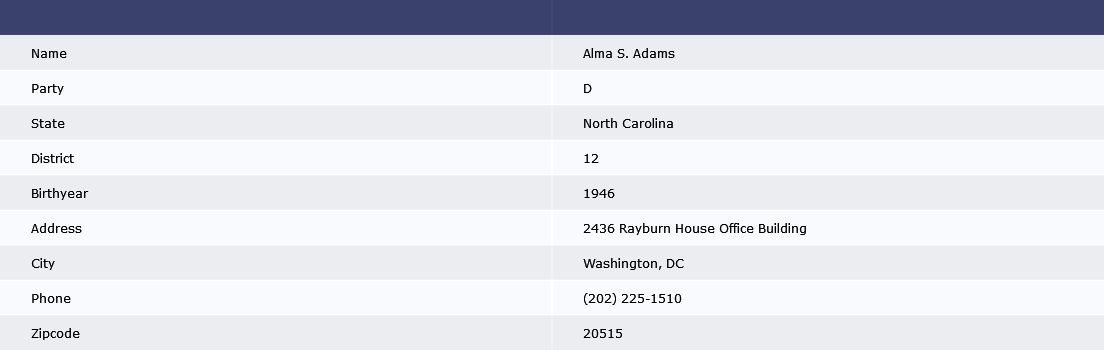

In [57]:
biotable(b)    